## CL-Gym Example: Stable A-GEM on Rotated MNIST

In this example, we use Averaged Gradient Episodic Memory (A-GEM) to train on Rotated MNIST benchmark. We use the stable version of [AGEM](https://arxiv.org/abs/1812.00420.pdf) using [Stable SGD](https://proceedings.neurips.cc/paper/2020/file/518a38cc9a0173d0b2dc088166981cf8-Paper.pdf) parameters.

## 1. Defining Parameters
First, we need to define our parameters/config for our experiment.
We define all our parameters inside a python dictionary. The parameters define different aspects of continual learning examples. For example:
-  How many tasks should we learn?
-  What our batch-size will be?
-  What Optimizer will we use?
-  Where should we store our outputs?

In [1]:
import torch
import cl_gym as cl
import numpy as np
import random
# first let's create params/config for our experiment
noise = 0.0

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # benchmark
            'seed': 2,
            'num_tasks': 5,
            'epochs_per_task': 1,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10,

            # algorithm
            'optimizer': 'SGD',
            'learning_rate': 0.01,
            'momentum': 0.8,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), }

#     trial_id = str(uuid.uuid4())
    trial_id = f"seed={params['seed']}_epoch={params['epochs_per_task']}_{noise=}__"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

def get_acc_task(task, meter, r = 3):
    return np.round(meter.data[task,1:task+1,-1], r)

def get_acc_mat(meter, r = 3):
    return np.round(meter.data[1:6,1:6,-1], r)

def get_overall_avg(meter, r = 3):
    avg_list = list()
    for i in range(1, 6):
        avg_list.append(np.mean(meter.data[i,1:i+1,-1]))
    return np.round(np.mean(avg_list), r)


In [10]:
from datasets.FairMNIST import NoiseMNIST
from trainers.FairContinualTrainer import FairContinualTrainer
from metrics.fair_metric_manager import FairMetricCollector
from algorithms.heuristic import Heuristic1

params = make_params()

seed = params['seed']
np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


benchmark = NoiseMNIST(num_tasks=params['num_tasks'], noise_size=noise, random_class_idx= False,
# benchmark = cl.benchmarks.SplitMNIST(num_tasks=params['num_tasks'],
                                        per_task_memory_examples=params['per_task_memory_examples'])
# backbone: MLP with 2 hidden layers
backbone = cl.backbones.MLP2Layers(input_dim=784, hidden_dim_1=256, hidden_dim_2=256, output_dim=10)

algorithm = Heuristic1(backbone, benchmark, params, requires_memory=True)
# algorithm = cl.algorithms.ERRingBuffer(backbone, benchmark, params)

# Callbacks
metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

# Make trainer
trainer = FairContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())


output_dir=./outputs/seed=2_epoch=1_noise=0.0__
[4 1 5 0 7 2 3 6 9 8]
---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 99.00803023145961, 'accuracy_s0': 99.33333333333333, 'accuracy_s1': 98.6879100281162, 'loss': 0.00015239887657484246}
training_task_end
len(train_loader.dataset)=64
---------------------------- Task 2 -----------------------
[2] Eval metrics for task 1 >> {'accuracy': 81.62494095418045, 'accuracy_s0': 87.23809523809524, 'accuracy_s1': 76.10121836925961, 'loss': 0.0037133694821277993}
[2] Eval metrics for task 2 >> {'accuracy': 97.0619658119658, 'accuracy_s0': 96.96969696969697, 'accuracy_s1': 97.1584699453552, 'loss': 0.0003795337556805621}
training_task_end
len(train_loader.dataset)=128
---------------------------- Task 3 -----------------------
[3] Eval metrics for task 1 >> {'accuracy': 70.71327350023618, 'accuracy_s0': 78.76190476190476, 'accuracy_s1': 62.79287722586692, 'loss': 0.007720074791023063}
[3] Eval m

In [11]:
get_acc_mat(metric_manager_callback.meters['accuracy'])

array([[99.008,  0.   ,  0.   ,  0.   ,  0.   ],
       [81.625, 97.062,  0.   ,  0.   ,  0.   ],
       [70.713, 80.449, 96.408,  0.   ,  0.   ],
       [72.839, 70.726, 70.68 , 98.018,  0.   ],
       [63.203, 68.323, 67.67 , 81.25 , 96.974]])

In [12]:
get_acc_mat(metric_manager_callback.meters['accuracy_s0'])

array([[99.333,  0.   ,  0.   ,  0.   ,  0.   ],
       [87.238, 96.97 ,  0.   ,  0.   ,  0.   ],
       [78.762, 82.236, 96.282,  0.   ,  0.   ],
       [81.048, 72.1  , 72.994, 97.674,  0.   ],
       [70.381, 68.234, 73.777, 83.923, 97.047]])

In [13]:
get_acc_mat(metric_manager_callback.meters['accuracy_s1'])

array([[98.688,  0.   ,  0.   ,  0.   ,  0.   ],
       [76.101, 97.158,  0.   ,  0.   ,  0.   ],
       [62.793, 78.579, 96.532,  0.   ,  0.   ],
       [64.761, 69.29 , 68.401, 98.366,  0.   ],
       [56.139, 68.415, 61.657, 78.55 , 96.903]])

In [14]:
get_overall_avg(metric_manager_callback.meters['accuracy'])

84.885

In [17]:
get_overall_avg(metric_manager_callback.meters['accuracy_s0'])

87.365

In [18]:
get_overall_avg(metric_manager_callback.meters['accuracy_s1'])

82.431

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import copy
import numpy as np
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.1307, 0.3081),
])

sensitive_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation([90, 90]),
    torchvision.transforms.RandomErasing(p = 1, scale=(0.02, 0.2)),
])

from datasets.FairMNIST import FairMNIST
dir = "/home/jaeyoung/anaconda3/envs/cil/lib/python3.9/site-packages/cl_gym/data"
train = FairMNIST(dir, train=True, download=True, transform=transforms)


In [ ]:
train_len = len(train)
train_sensitive_idx = np.sort(np.random.choice(train_len, train_len//2, replace=False))
print(train_sensitive_idx)
sensitive = np.zeros(train_len)
sensitive[train_sensitive_idx] = np.ones_like(train_sensitive_idx)
print(sensitive)

[    1     3     4 ... 59995 59996 59998]
[0. 1. 0. ... 0. 1. 0.]


In [ ]:
def bool2idx(arr):
    idx = list()
    for i, e in enumerate(arr):
        if e == 1:
            idx.append(i)
    return np.array(idx)
train.data[bool2idx(sensitive)].shape

torch.Size([30000, 28, 28])

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import copy

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.1307, 0.3081),
])

sensitive_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation([90, 90]),
    torchvision.transforms.RandomErasing(p = 1, scale=(0.02, 0.1)),
])


In [ ]:
from cl_gym.benchmarks.utils import DEFAULT_DATASET_DIR
from cl_gym.benchmarks.transforms import get_default_mnist_transform
mnist_train = torchvision.datasets.MNIST(DEFAULT_DATASET_DIR, train=True, download=True, transform=transforms)
original = copy.deepcopy(mnist_train.data)

In [ ]:
import numpy as np
a = np.sort(np.random.choice(len(mnist_train), len(mnist_train)//2, replace=False))
a

array([    0,     1,     4, ..., 59996, 59998, 59999])

Text(0.5, 1.0, 'transform')

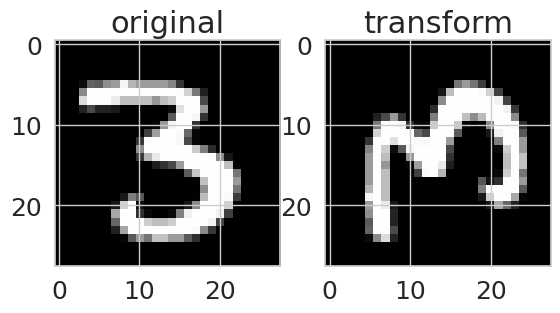

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt


idx = 12

img = original[idx]
trans = sensitive_transform(mnist_train.data)[idx]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(trans), cmap='gray')
plt.title('transform')


In [ ]:
def tranform_on_idx(data, idx, transform):
    # if len(data) != len(idx):
    #     raise ValueError(f"size of data({len(data)}) and index({len(idx)}) is different")
    transformed = transform(data[idx])
    data[idx] = transformed
    return data

In [ ]:
data = tranform_on_idx(mnist_train.data, a, sensitive_transform)

Text(0.5, 1.0, 'transform')

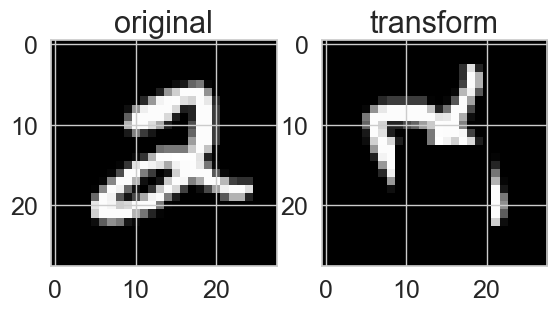

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt


idx = 5
img = original[idx]
trans = data[idx]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(trans), cmap='gray')
plt.title('transform')
